## Dataset

- You can access the dataset : https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [ ]:
# get the data
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2022-09-16 12:26:27--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  19.6MB/s    in 8.4s    

2022-09-16 12:26:36 (9.58 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



## Import Library

In [ ]:
! pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 11.1 MB/s 
     |████████████████████████████████| 120 kB 34.5 MB/s 
     |████████████████████████████████| 6.6 MB 8.5 MB/s 


In [ ]:
import os
import pandas as pd
import numpy as np
import nltk
import re
import time

from tqdm import tqdm
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, recall_score, \
                            accuracy_score, precision_recall_fscore_support

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler


# transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

nltk.download('punkt')
nltk.download('stopwords')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Read Dataset

In [ ]:
train_docs = []
train_labels = []

for filename in tqdm(os.listdir('aclImdb/train/pos/'), desc='Read Train Positive'):
  with open('aclImdb/train/pos/' + filename) as f:
    try:
      doc = f.read()
      train_docs.append(doc)
      train_labels.append(1)
    except IOError:
      pass

for filename in tqdm(os.listdir('aclImdb/train/neg/'), desc='Read Train Negative'):
  with open('aclImdb/train/neg/' + filename) as f:
    try:
      doc = f.read()
      train_docs.append(doc)
      train_labels.append(0)
    except IOError:
      pass

print('\nNumber of Documents (train):', len(train_docs))

Read Train Negative: 100%|██████████| 12500/12500 [00:00<00:00, 17614.27it/s]


Number of Documents (train): 25000


In [ ]:
test_docs = []
test_labels = []

for filename in tqdm(os.listdir('aclImdb/test/pos/'), desc='Read Test Positive'):
  with open('aclImdb/test/pos/' + filename) as f:
    try:
      doc = f.read()
      test_docs.append(doc)
      test_labels.append(1)
    except IOError:
      pass

for filename in tqdm(os.listdir('aclImdb/test/neg/'), desc='Read Test Negative'):
  with open('aclImdb/test/neg/' + filename) as f:
    try:
      doc = f.read()
      test_docs.append(doc)
      test_labels.append(0)
    except IOError:
      pass

print('\nNumber of Documents (test):', len(test_docs))

Read Test Negative: 100%|██████████| 12500/12500 [00:00<00:00, 38109.97it/s]


Number of Documents (test): 25000


## Traditional 

### Preprocessing

1. Normalization : lowercasing, removing HTML, trimming
2. Removing Stopwords (using NLTK)
3. Stemming 

#### 1. Normalization : lowercasing, removing HTML, trimming 

In [ ]:
def normalization(doc):
  normal_doc = doc.lower() #lowercasing
  normal_doc = re.sub('</?\s*\w+\s*/?>', ' ', normal_doc) #removing html
  normal_doc = re.sub('\s+', ' ', normal_doc) #remove extra space
  normal_doc = normal_doc.strip() #trim

  return normal_doc

####2. Removing Stopwords (using NLTK)

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(doc):
  token = nltk.word_tokenize(doc)
  token_afterremoval = []
  for k in token:
    if k not in stopwords:
      token_afterremoval.append(k)
  
  str_clean = ' '.join(token_afterremoval)
  return str_clean

####3. Stemming (optional)

In [ ]:
ps = PorterStemmer()

def stemming(doc):
  token = nltk.word_tokenize(doc)
  stemmed_token = [ps.stem(t) for t in token]
  
  str_stemmed = ' '.join(stemmed_token)
  return str_stemmed

#### Pipeline preprocessing

In [ ]:
def preprocessing(docs):
  preprocessed_docs = []
  for doc in tqdm(docs, desc='Preprocessing'):
    normal_doc = normalization(doc)
    nosw_doc = remove_stopwords(normal_doc)
    #stem_doc = stemming(nosw_doc)
    preprocessed_docs.append(nosw_doc)
  return preprocessed_docs

In [ ]:
print('Preprocessing Train Data')
preprocessed_train_docs = preprocessing(train_docs)
print("========================")

print("Preprocessing Test Data")
preprocessed_test_docs = preprocessing(test_docs)

Preprocessing Train Data


Preprocessing: 100%|██████████| 25000/25000 [01:08<00:00, 366.97it/s]


Preprocessing Test Data


Preprocessing: 100%|██████████| 25000/25000 [00:55<00:00, 450.26it/s]


Example

In [ ]:
def show_some_docs(docs, doc_type, max=1):
  print(doc_type)
  print("=========================")
  for doc in docs[:max]:
    print(doc)
  print()

show_some_docs(train_docs, "Before Preprocessing")
show_some_docs(preprocessed_train_docs, "After Preprocessing")

Before Preprocessing
Just saw the movie, and the scary thing was, the people talking during the movie sounded just like the actors. The movie had its moments, but also lagged and was rather sick. It was all meant to be a farce, but once you see the pathetic lives of the people in the movie, you think to yourself "People like this are all around us" All attempts at getting the audience's sympathy are dashed as the actors do one stupid thing after another. On the plus side, there are some great (and funny) insults. I think I would wait for video- but it was a good laugh. WARNING- Jerry takes his shirt off during the movie!! (not a pretty sight!)

After Preprocessing
saw movie , scary thing , people talking movie sounded like actors . movie moments , also lagged rather sick . meant farce , see pathetic lives people movie , think `` people like around us '' attempts getting audience 's sympathy dashed actors one stupid thing another . plus side , great ( funny ) insults . think would wait 

#### Wordcloud

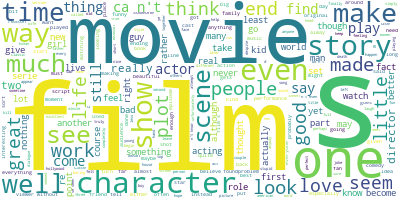

In [ ]:
long_string = ';'.join(preprocessed_train_docs)

wordcloud = WordCloud(background_color='white',
                      max_words=5000,
                      contour_width=5,
                      contour_color='steelblue')

wordcloud.generate(long_string)

wordcloud.to_image()

### Feature Extraction

TF-IDF : weighted Bag-of-Words

In [ ]:
vectorizer = TfidfVectorizer(max_features = 5000)

train_tfidf = vectorizer.fit_transform(np.array(preprocessed_train_docs))
test_tfidf = vectorizer.transform(np.array(preprocessed_test_docs))

### Sentiment Classification

#### Cross Validation

In [ ]:
start_time = time.time()

X = train_tfidf
y = train_labels

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(MultinomialNB(), X, y, cv=10, scoring=scoring)
print("Execution Time (s): {:.2f}".format(time.time() - start_time))
print("=======================")
print("Accuracy :", np.mean(scores['test_accuracy']))
print("Macro-precision :", np.mean(scores['test_precision_macro']))
print("Macro-Recall :", np.mean(scores['test_recall_macro']))
print("Macro-F1 :", np.mean(scores['test_f1_macro']))
print("=======================")

Execution Time (s): 0.37
Accuracy : 0.8525600000000001
Macro-precision : 0.8527028678209472
Macro-Recall : 0.8525600000000001
Macro-F1 : 0.8525443494840529


In [ ]:
nb = MultinomialNB()
nb.fit(train_tfidf, train_labels)

y_pred = nb.predict(test_tfidf)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.85      0.82      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



## BERT

In [ ]:
# Hyperparameter

test_portion = 0.3
batch_size = 32
max_length = 128
SAVE_PERIOD = 1
epochs = 2

nested-split : train-validation-test

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_docs,
                                                  train_labels,
                                                  test_size=test_portion,
                                                  random_state=245)
x_test, y_test = test_docs, test_labels

In [ ]:
# Download pre-trained BERT model and tokenizer

model = TFBertForSequenceClassification.from_pretrained("bert-base-cased")
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Preprocessing data (BERT Model):

- converting documents into input for BERT
- data is converted into InputExamples to match the Transformers library
- InputExamples are entered as input to the tokenizer, then the output is a dataset in Tensorflow format.

In [ ]:
 # convert data to examples
def convert_data_to_examples(x_train, x_val, x_test, y_train, y_val, y_test):
  train_InputExamples = [InputExample(guid = None,
                                      text_a = text,
                                      text_b = None,
                                      label = label) for text, label in zip(x_train, y_train)]
  validation_InputExamples = [InputExample(guid = None,
                                           text_a = text,
                                           text_b = None,
                                           label = label) for text, label in zip(x_val, y_val)] 
  test_InputExamples = [InputExample(guid=None,
                                      text_a = text, 
                                      text_b = None,
                                      label = label) for text, label in zip(x_test, y_test)]
  return pd.Series(train_InputExamples), pd.Series(validation_InputExamples), pd.Series(test_InputExamples)       

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )                                                                      

In [ ]:
train_InputExamples, validation_InputExamples, test_InputExamples = convert_data_to_examples(x_train,
                                                                                           x_val,
                                                                                           x_test,
                                                                                           y_train,
                                                                                           y_val,
                                                                                           y_test)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer, max_length)
train_data = train_data.shuffle(100).batch(batch_size).repeat(epochs)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer, max_length)
validation_data = validation_data.batch(batch_size).repeat(epochs)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer, max_length)
test_data = test_data.batch(batch_size)                                                                                           

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2306: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


BERT architecture:
- BERT model
- Dropout layer
- Dense layer : for classification

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


To prevent overfitting:
1. Checkpoint: Tensorflow will save the model every few times according to the definition from the user.
2. Reduce Learning Rate: Reduces learning rate if the monitored variable (default: validation loss) does not improve with epoch
3. Early Stopping:
Terminate before the entire epoch is finished if it turns out that performance continues to deteriorate or does not improve

In [ ]:
# Checkpoint
checkpoint = ModelCheckpoint(
    './base.model',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    mode = 'min',
    save_weights_only = False,
    period = SAVE_PERIOD
)

# Reduce learning rate if not improved
reduceLR = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 1,
    verbose = 1,
    mode = 'auto'
)

# Early stopping
earlystop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    verbose = 1,
    mode = 'auto'
)

callbacks = [checkpoint, earlystop, reduceLR]

#### Training the Model

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5,
                                                   epsilon = 1e-8,
                                                   clipnorm = 1.0),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history = model.fit(
    train_data,
    steps_per_epoch = len(x_train) // batch_size,
    epochs = epochs,
    validation_data = validation_data,
    validation_steps = len(y_train) // batch_size,
    callbacks = callbacks
)

Epoch 1/2
546/546 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8183


Epoch 1: val_loss improved from inf to 0.31409, saving model to ./base.model


546/546 [==============================] - 412s 717ms/step - loss: 0.3899 - accuracy: 0.8183 - val_loss: 0.3141 - val_accuracy: 0.8604 - lr: 3.0000e-05
Epoch 2/2
546/546 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.9206

546/546 [==============================] - 272s 498ms/step - loss: 0.2039 - accuracy: 0.9206 - lr: 3.0000e-05


In [ ]:
import math

num_labels = 2

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def normalize(x):
  return [i/sum(x[:num_labels]) for i in x[:num_labels]]

def print_scores(model, test_data, y_test):
  start_time = time.time()
  test_predictions = model.predict(test_data)
  try:
    predictions = [np.argmax(i) if np.argmax(i) < num_labels else 0 for i in test_predictions.get('logits')]
    predictions_proba = [normalize([sigmoid(j) for j in i])[1] for i in test_predictions.get('logits')]
  except:
    predictions = [1 if i >= 0.5 else 0 for i in test_predictions]
    predictions_proba = [i for i in test_predictions]

  y_true = [i for i in y_test]

  print("Inference Time: {:.2f}".format(time.time() - start_time))
  print(classification_report(y_true, predictions))

print_scores(model, test_data, y_test)

Inference Time: 141.36
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     12500
           1       0.86      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [ ]:
if tf.config.list_physical_devices('GPU'):
  usage = tf.config.experimental.get_memory_info('GPU:0')
  print('Current: {:,} Byte(s)'.format(usage['current']))
  print('Peak: {:,} Byte(s)'.format(usage['peak']))

Current: 2,332,533,504 Byte(s)
Peak: 7,680,108,800 Byte(s)
